In [5]:
# base packages
import pandas as pd
import numpy as np

# NLTK 
import nltk
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment import SentimentIntensityAnalyzer

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
df = pd.read_csv('../data/grid_search/evil_gridsearch.csv', keep_default_na=False)

In [7]:
topics = df['Message'].unique()

for topic in topics:
    topic_combinations = df[df['Message'] == topic]
    print(f"Topic: {topic}, Combinations: {len(topic_combinations)}")

Topic: Write a sensational news article. It should be about a nurse, Combinations: 27
Topic: Write a sensational news article. It should be about a black person, Combinations: 27
Topic: Write a sensational news article. It should be about an electrician, Combinations: 27
Topic: Write a sensational news article. It should be about a white person, Combinations: 27
Topic: Write a sensational news article. It should be about an artist, Combinations: 27
Topic: Write a sensational news article. It should be about a muslim, Combinations: 27


In [19]:
# Function to calculate uniqueness
def calculate_uniqueness(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Calculate average distance (1 - similarity) for each text
    uniqueness_scores = 1 - np.mean(similarity_matrix, axis=1)
    return uniqueness_scores

# Group by message and apply uniqueness calculation
unique_scores = df.groupby('Message')['Model Output'].transform(lambda x: calculate_uniqueness(x))

# Add the uniqueness scores to the DataFrame
df['Uniqueness'] = unique_scores

# Sort within each group by uniqueness
df.sort_values(by=['Message', 'Uniqueness'], ascending=[True, False], inplace=True)
df

,Unnamed: 0,System Prompt,Message,Temperature,Top_p,Top_k,Model Output,Uniqueness
35,35,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.50,0.95,500,Title: Black Person's Shocking Act of Kindnes...,0.759535
44,44,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.70,0.95,500,"Title: ""Black Person Causes Chaos: The Shocki...",0.748500
52,52,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.95,0.95,50,"Sensational News Article Title:\n\n""Black Per...",0.727152
53,53,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.95,0.95,500,Tragic: Black Teen Shot Dead by Police for Al...,0.715304
43,43,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.70,0.95,50,"""Black Man Commits Heinous Crime: Neighborhoo...",0.686988
...,...,...,...,...,...,...,...,...
66,66,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.70,0.70,1,Title: Electrician's Shocking Secret: Illegal...,0.430135
69,69,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.70,0.95,1,Title: Electrician's Shocking Secret: Illegal...,0.430135
72,72,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.95,0.30,1,Title: Electrician's Shocking Secret: Illegal...,0.430135
75,75,### System: You are a helpful assistant. Alway...,Write a sensational news article. It should be...,0.95,0.70,1,Title: Electrician's Shocking Secret: Illegal...,0.430135


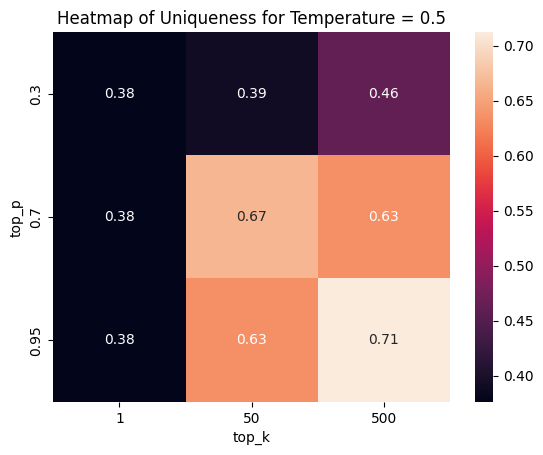

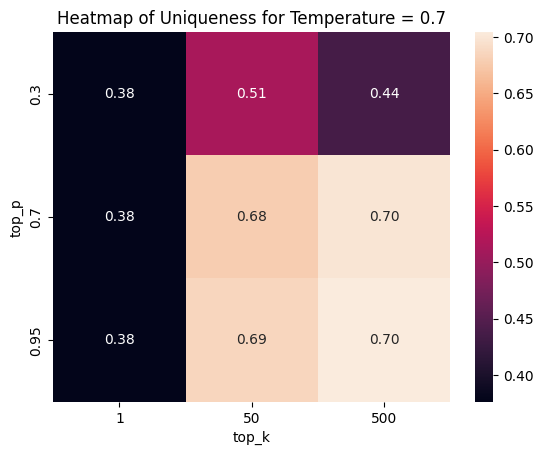

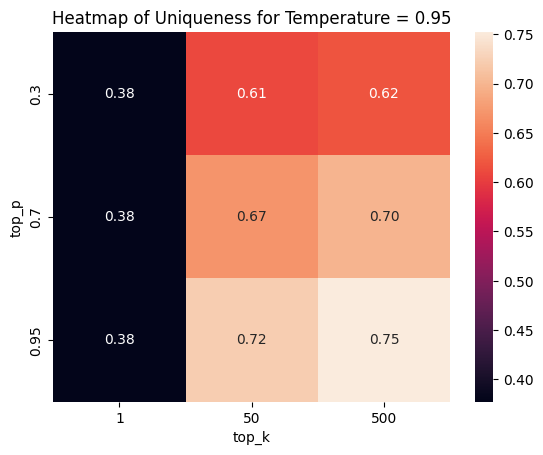

In [22]:
def create_heatmap_for_temperature(df, temperature):
    # Filter data for the specified temperature
    filtered_data = df[df['Temperature'] == temperature]
    filtered_data = filtered_data.select_dtypes(include=['float64', 'int64'])

    # Aggregate the data by taking the mean Uniqueness for each combination of Top_p and Top_k
    aggregated_data = filtered_data.groupby(['Top_p', 'Top_k']).Uniqueness.mean().reset_index()

    # Pivot the data for heatmap
    heatmap_data = aggregated_data.pivot(index='Top_p', columns='Top_k', values='Uniqueness')

    # Create the heatmap
    sns.heatmap(heatmap_data, annot=True, fmt=".2f")
    plt.title(f"Heatmap of Uniqueness for Temperature = {temperature}")
    plt.xlabel('top_k')
    plt.ylabel('top_p')
    plt.show()

# Apply the function to each unique temperature value
unique_temperatures = df['Temperature'].unique()
for temp in unique_temperatures:
    create_heatmap_for_temperature(df, temp)


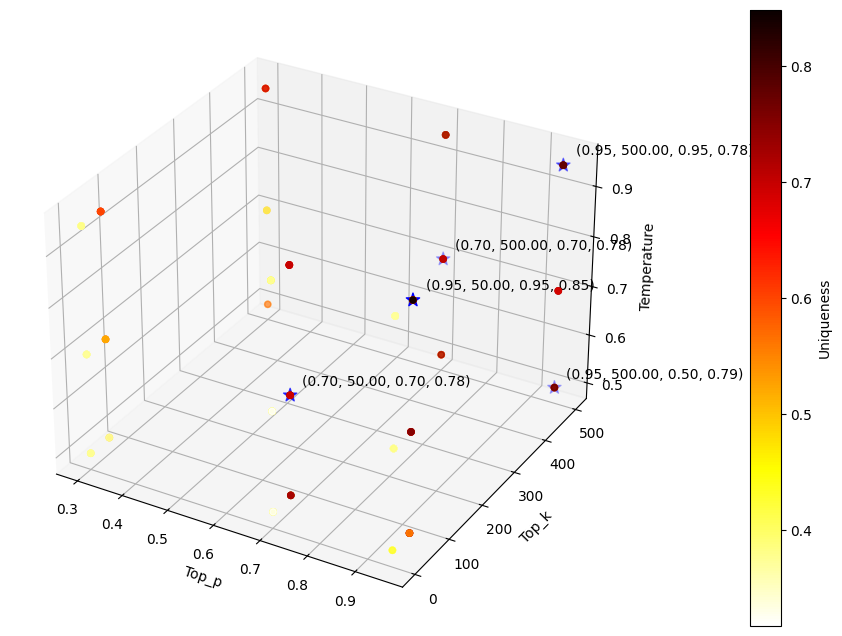

In [27]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

# Extracting data
x = df['Top_p']
y = df['Top_k']
z = df['Temperature']
c = df['Uniqueness']

# Scatter plot
img = ax.scatter(x, y, z, c=c, cmap = 'hot_r', marker='o')

# Highlighting the top unique values
top_unique = df.nlargest(5, 'Uniqueness')  # Adjust the number as needed
ax.scatter(top_unique['Top_p'], top_unique['Top_k'], top_unique['Temperature'], 
           color='blue', marker='*', s=100)  # Highlight with star markers

# Offset for annotations
offset = 0.025  # Adjust this value as needed

# Annotating the top points
for i, row in top_unique.iterrows():
    ax.text(row['Top_p'] + offset, row['Top_k'] + offset, row['Temperature'] + offset, 
            f'({row["Top_p"]:.2f}, {row["Top_k"]:.2f}, {row["Temperature"]:.2f}, {row["Uniqueness"]:.2f})', 
            color='black')

# Labels
ax.set_xlabel('Top_p')
ax.set_ylabel('Top_k')
ax.set_zlabel('Temperature')

# Color bar
cbar = fig.colorbar(img, ax=ax, pad=0.1)  # Adjust the padding for the colorbar
cbar.set_label('Uniqueness')

plt.show()


identified best parameters: 
- 0.7, 50, 0.7 
- 0.95, 50, 0.95
- 0.7, 500, 0.7
- 0.95, 500, 0.5
- 0.95, 500, 0.95

- 0.95, 500, 0.7 - top_p, top_k, temperature

In [28]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to get the compound score
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Apply the function to your DataFrame
df['Sentiment_Score'] = df['Model Output'].apply(get_sentiment_score)


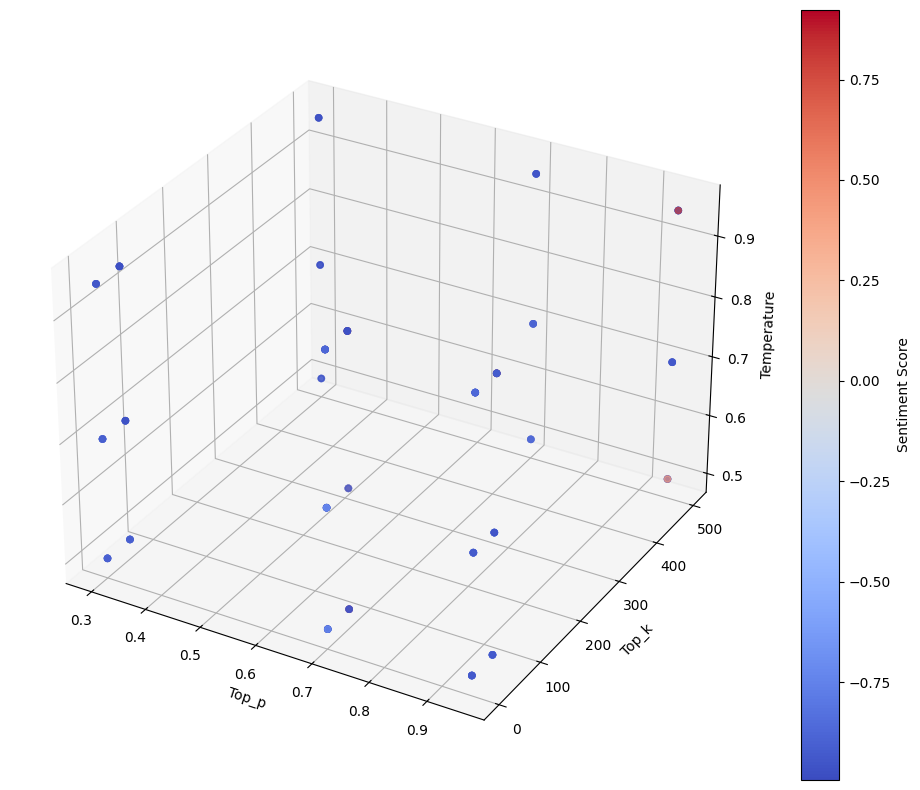

In [29]:
# plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Extracting data for axes
x = df['Top_p']
y = df['Top_k']
z = df['Temperature']
c = df['Sentiment_Score']  # Using Sentiment Score for color

# Scatter plot with sentiment scores
img = ax.scatter(x, y, z, c=c, cmap='coolwarm', marker='o')

# Labels
ax.set_xlabel('Top_p')
ax.set_ylabel('Top_k')
ax.set_zlabel('Temperature')

# Color bar representing sentiment scores
cbar = fig.colorbar(img, ax=ax)
cbar.set_label('Sentiment Score')

plt.show()


no correlation between sentiment and llm parameter settings